# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- а нализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

Задача:постройть модель, которая по фотографии определит приблизительный возраст человека. В распоряжении набор фотографий людей с указанием возраста. MAE не должно превышать 8.

## Исследовательский анализ данных

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
data = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
display(data.head())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [6]:
print(data.isna().sum())

file_name    0
real_age     0
dtype: int64


In [7]:
print('Количество дубликатов строк в data :',data.duplicated().sum())

Количество дубликатов строк в data : 0


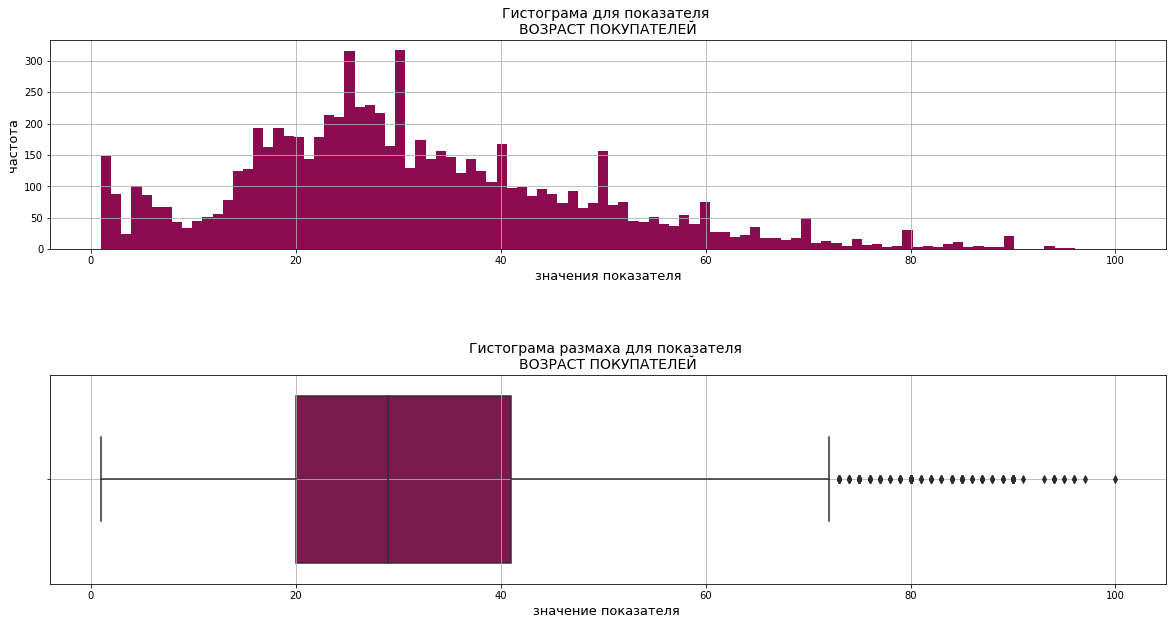

In [8]:
plt.figure(figsize=[20,10])
plt.subplots_adjust(wspace=0.4, hspace=0.6)

plt.subplot(211)

plt.hist(data["real_age"],bins = 100, color = '#8B0A50')#,bins=100,figsize=(20, 7),grid=True)
plt.title(f'Гистограма для показателя \nВОЗРАСТ ПОКУПАТЕЛЕЙ', fontsize=14)
plt.xlabel('значения показателя', fontsize=13)
plt.grid(True)
plt.ylabel('частота', fontsize=13);

plt.subplot(212)
sns.boxplot(data["real_age"], color = '#8B0A50')
plt.title(f'Гистограма размаха для показателя \nВОЗРАСТ ПОКУПАТЕЛЕЙ', fontsize=14)
plt.xlabel('значение показателя ', fontsize=13)
plt.grid(True);

In [9]:
print(data.describe())

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


In [10]:
train_datagen = ImageDataGenerator(rescale=1./255)
train = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


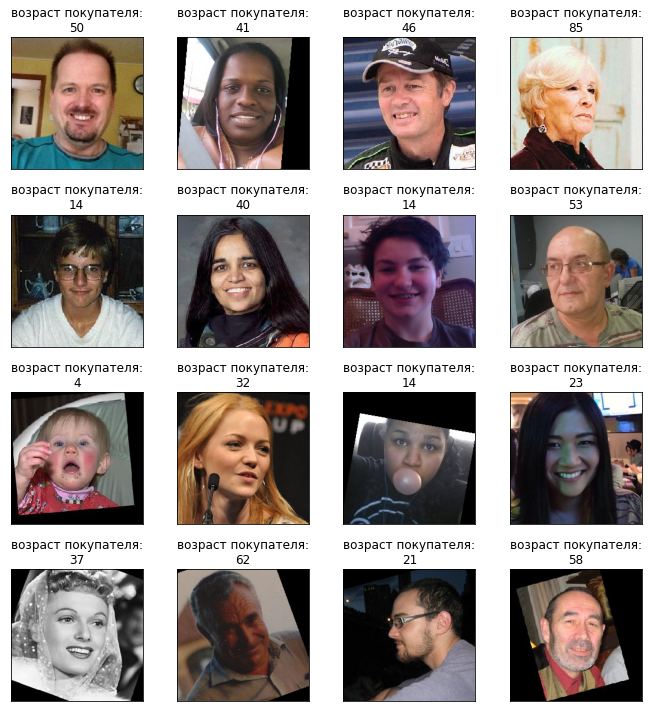

In [11]:
features, target = next(train)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(f'возраст покупателя:\n{target[i]}')

### ВЫВОД:
В представленном датасете находится 7591 фотография.

После первичного знакомства с данными было установлено, что отсутствуют пропуски и дубликаты, типы данных присвоены правильно.

Возрастной диапазон покупателей от 20 до 41 года. Также есть дети. Самый маленький возраст ребенка - 1 год. Также есть и пенсионеры. Максимальный возраст пенсионера - 100 лет.

Фото, представленные в данном датасете, обладают рядом особенностей:
- есть пользователи, которые не смотрят в объектив;
- есть пользователи, которые корчат гримасы;
- есть посторонние объекты, а именно:
  - головные уборы;
  - очки;
  - различные предметы (микрофон, свечи от торта, жевачка...);
  - руки у лица;
- присутствуют сильно уменьшенные фото, перевенутые и  фото с плохим качеством.

Исходя из представленных фотографий модели будет непросто оценивать возраст.

## Обучение модели

In [12]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf

In [13]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow

In [14]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow

In [15]:
def create_model(input_shape):
 
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
 
 
    return model

In [16]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

**epochs = 5, weights='imagenet', include_top=False, activation='relu', batch_size=16**

Epoch 1/5
356/356 - 50s - loss: 207.0520 - mae: 10.4428 - val_loss: 593.8736 - val_mae: 19.2493

Epoch 2/5
356/356 - 41s - loss: 83.7391 - mae: 6.9516 - val_loss: 122.7209 - val_mae: 8.2682

Epoch 3/5
356/356 - 41s - loss: 58.3933 - mae: 5.8252 - val_loss: 84.3765 - val_mae: 6.9096

Epoch 4/5
356/356 - 42s - loss: 44.6935 - mae: 5.1448 - val_loss: 85.3613 - val_mae: 7.1507

Epoch 5/5
356/356 - 42s - loss: 33.3666 - mae: 4.3699 - val_loss: 72.6102 - val_mae: 6.4931

119/119 - 10s - loss: 72.6102 - **mae: 6.4931**

**epochs = 5, weights='imagenet', include_top=False, activation='relu', batch_size=32**

Epoch 1/5
178/178 - 81s - loss: 223.4577 - mae: 10.6826 - val_loss: 855.8170 - val_mae: 24.3749

Epoch 2/5
178/178 - 39s - loss: 78.0646 - mae: 6.6383 - val_loss: 619.6707 - val_mae: 19.6916

Epoch 3/5
178/178 - 38s - loss: 48.5706 - mae: 5.2789 - val_loss: 267.3594 - val_mae: 12.7462

Epoch 4/5
178/178 - 38s - loss: 34.3749 - mae: 4.4765 - val_loss: 120.6023 - val_mae: 8.3101

Epoch 5/5
178/178 - 39s - loss: 26.4733 - mae: 3.9244 - val_loss: 86.1292 - val_mae: 6.9858

60/60 - 9s - loss: 86.1292 - **mae: 6.9858**

**epochs = 5, weights='imagenet', include_top=False, activation='softmax', batch_size=16**

Epoch 1/5
356/356 - 51s - loss: 1241.2842 - mae: 30.7292 - val_loss: 1099.8462 - val_mae: 28.6162

Epoch 2/5
356/356 - 42s - loss: 1241.2842 - mae: 30.7292 - val_loss: 1099.8462 - val_mae: 28.6162

Epoch 3/5
356/356 - 43s - loss: 1241.2842 - mae: 30.7292 - val_loss: 1099.8462 - val_mae: 28.6162

Epoch 4/5
356/356 - 41s - loss: 1241.2842 - mae: 30.7292 - val_loss: 1099.8462 - val_mae: 28.6162

Epoch 5/5
356/356 - 42s - loss: 1241.2842 - mae: 30.7292 - val_loss: 1099.8462 - val_mae: 28.6162

119/119 - 10s - loss: 1099.8462 - **mae: 28.6162**

**epochs = 5, weights=None, include_top=False, activation='relu', batch_size=16**

Epoch 1/5
356/356 - 50s - loss: 366.3229 - mae: 14.6402 - val_loss: 281.0062 - val_mae: 13.0577

Epoch 2/5
356/356 - 42s - loss: 275.4128 - mae: 12.8171 - val_loss: 311.3676 - val_mae: 13.9345

Epoch 3/5
356/356 - 41s - loss: 250.7323 - mae: 12.2257 - val_loss: 275.1759 - val_mae: 13.5482

Epoch 4/5
356/356 - 41s - loss: 231.9590 - mae: 11.7781 - val_loss: 260.6159 - val_mae: 12.9185

Epoch 5/5
356/356 - 41s - loss: 217.5811 - mae: 11.3865 - val_loss: 199.3397 - val_mae: 11.1865

119/119 - 10s - loss: 199.3397 - **mae: 11.1865**

**epochs = 10, weights='imagenet', include_top=False, activation='relu', batch_size=16**

Epoch 1/10
356/356 - 49s - loss: 215.6618 - mae: 10.5932 - val_loss: 682.8648 - val_mae: 21.0536

Epoch 2/10
356/356 - 39s - loss: 115.6618 - mae: 6.6732 - val_loss: 452.8788 - val_mae: 8.0536
Epoch 3/10
356/356 - 39s - loss: 58.5697 - mae: 5.8710 - val_loss: 74.1233 - val_mae: 6.4501

Epoch 4/10
356/356 - 39s - loss: 41.5079 - mae: 4.9254 - val_loss: 80.6526 - val_mae: 6.6924

Epoch 5/10
356/356 - 39s - loss: 31.8822 - mae: 4.3399 - val_loss: 75.1605 - val_mae: 6.4739

Epoch 6/10
356/356 - 39s - loss: 27.0071 - mae: 3.9761 - val_loss: 90.8470 - val_mae: 7.3296

Epoch 7/10
356/356 - 39s - loss: 23.9787 - mae: 3.7628 - val_loss: 82.7222 - val_mae: 6.7076

Epoch 8/10
356/356 - 39s - loss: 18.1222 - mae: 3.2440 - val_loss: 63.9242 - val_mae: 5.9661

Epoch 9/10
356/356 - 39s - loss: 14.4457 - mae: 2.8862 - val_loss: 70.1126 - val_mae: 6.4136

Epoch 10/10
356/356 - 39s - loss: 13.5397 - mae: 2.8144 - val_loss: 64.0902 - val_mae: 5.8750

119/119 - 10s - loss: 64.0902 - **mae: 5.8750**

### ВЫВОД:
Была построена медель сверточной нейронной сети на ResNet50. Были инециализированы весы ImageNet, также в конце архитектуры было принято решение не задавать слои GlobalAveragePooling2D и Dense.

Поскольку датасет относительно большой было принято решение не замораживать веса. Размер батча был принят равный 16, оптимизатор был выбран 'relu' для полносвязанного слоя. Количество эпох достатосно и 5. При 10 эпохах наблюдается спад MAE. Не наблюдается переобучение модели.


За 10 эпох обучения показатель MAE на тестовой выборке стал равен 5.8750, что удовлетворяет потавленной задаче.

## Анализ обученной модели

Обученная модель позволяет с высокой точностью предсказывать возраст покупателей. 

Получение значения МАЕ 6 - хороший показатель, поскольку для категорий пользователей погрешность в 8 - 12 лет - является нормой, в представленных вычислениях метрика ниже.

Использование GPU-тренажёра и нейронных сетей позволяет быстро и эффективно обработать большое количество информации с высокой точностью.